# 0.0 IMPORTS 

In [35]:
import math
import pandas as pd 
import inflection 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime
from matplotlib.gridspec import GridSpec

from IPython.display import Image

## LOADING DATA 

In [36]:
df_sales_raw=pd.read_csv(r"C:\Users\55149\OneDrive - Fatec Centro Paula Souza\Documents\repos\ds_producao\train.csv", low_memory=False)
df_store_raw=pd.read_csv(r"C:\Users\55149\OneDrive - Fatec Centro Paula Souza\Documents\repos\ds_producao\store.csv", low_memory=False)

#merge
df_raw=pd.merge(df_sales_raw, df_store_raw, how='left', on ='Store')

# 1.0 PASSO 01 - DESCRICAO DE DADOS 

In [37]:
df1=df_raw.copy()

## RENAME COLUMNS

In [38]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase= lambda x: inflection.underscore(x)

cols_new=list(map(snakecase,cols_old))

#rename

df1.columns=cols_new

## 1.2. DATA DIMENSIONS 

In [39]:
print('number of rows: {}'.format(df1.shape[0]))
print('number of cols: {}'.format(df1.shape[1]))

number of rows: 1017209
number of cols: 18


## 1.3.DATA TYPES

In [40]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. FILLOUT NA 

In [41]:
#competition_distance
df1['competition_distance']=df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

                              
#promo2_since_week
df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval 
month_map={1:'Jan', 2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)
df1['month_map']=df1['date'].dt.month.map(month_map)

df1['is_promo']=df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.5.  CHANGE TYPES

In [42]:
df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int)

df1['promo2_since_week']=df1['promo2_since_week'].astype(int)
df1['promo2_since_year']=df1['promo2_since_year'].astype(int)

## 1.6. DESCRIPTIVE STATISCAL

In [43]:
atributo_num=df1.select_dtypes(include=['int64','float64','int32'])
atributo_cat=df1.select_dtypes(exclude=['int64','int32','float64','datetime64[ns]'])

## 1.6.1. NUMERICAL ATTRIBUTES

In [44]:
#tendencia central- média, mediana 
ct1=pd.DataFrame(atributo_num.apply(np.mean)).T
ct2=pd.DataFrame(atributo_num.apply(np.median)).T


#dispersão- desvio padrão, min, max, range, skew, kurtosis
d1=pd.DataFrame(atributo_num.apply(np.std)).T
d2=pd.DataFrame(atributo_num.apply(min)).T
d3=pd.DataFrame(atributo_num.apply(max)).T
d4=pd.DataFrame(atributo_num.apply(lambda x: x.max()-x.min())).T
d5=pd.DataFrame(atributo_num.apply(lambda x: x.skew())).T
d6=pd.DataFrame(atributo_num.apply(lambda x: x.kurtosis())).T

# concatenate

m=pd.concat([d2,d3,d4,ct2,ct2,d1,d5,d6]).T.reset_index()
m.columns=['atributos','min','max','range','média','mediana','std','skew','kurtosis']

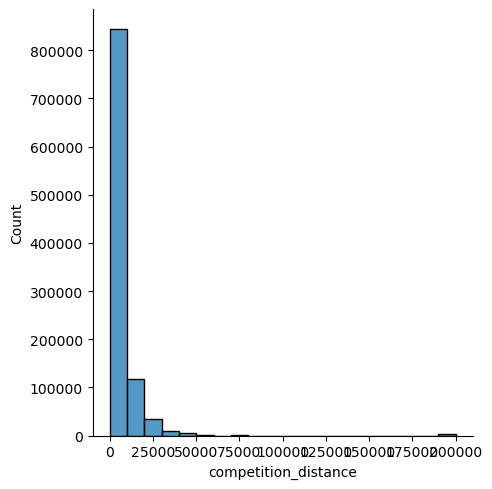

In [45]:
sns.displot(df1['competition_distance'],bins=20)

## ATRIBUTOS CATEGÓRICOS

In [46]:
atributo_cat.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

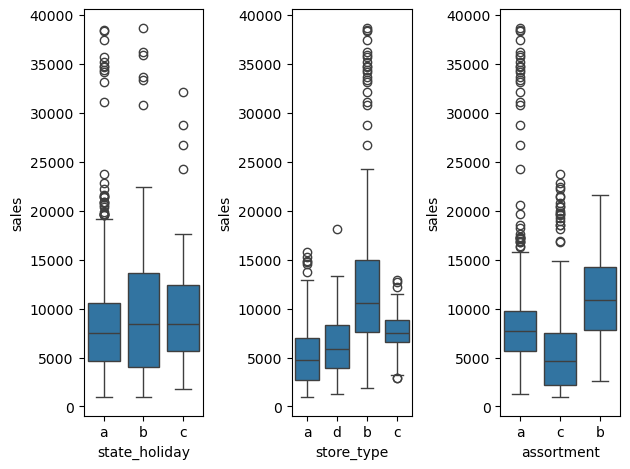

In [47]:
aux1=df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1 )

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1 )

plt.tight_layout()
plt.show()

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [48]:
df2=df1.copy()

## 2.1.MAPA MENTAL DE HIPOTESES 

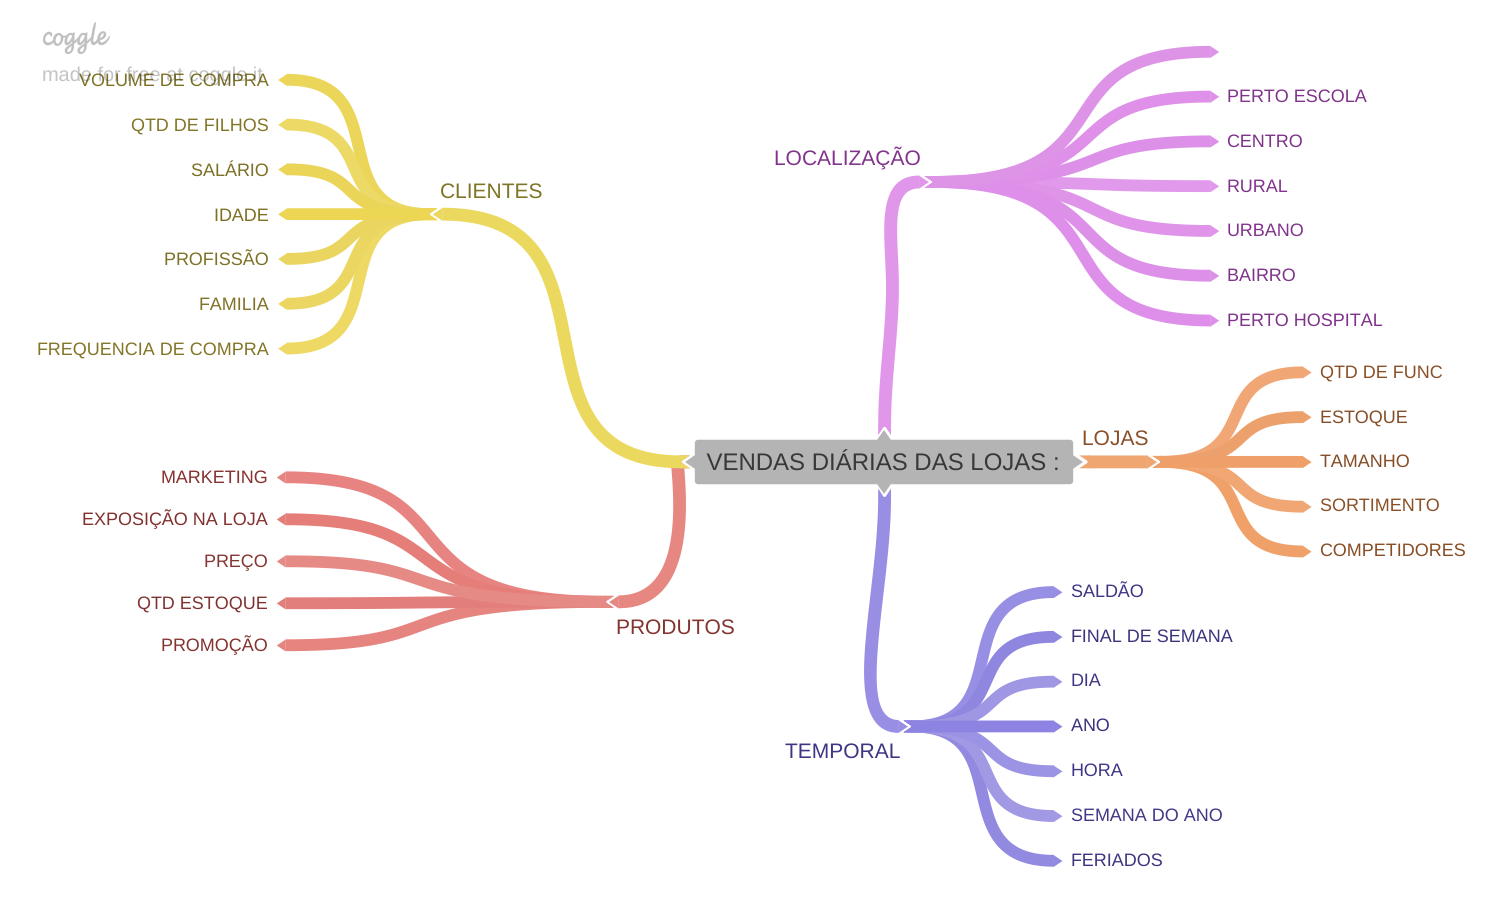

In [49]:
Image(r"C:\Users\55149\OneDrive - Fatec Centro Paula Souza\Documents\repos\ds_producao\img\MindMapHypothesis.png")

## 2.1. CRIAÇÃO DE HIPOTESES 

### 2.1.1. HIPOTESE LOJA 

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2. HIPOTESE PRODUTO 

**1.** lojas que investem mais em marketing deveriam vender mais.

**2.** lojas que expoem produtos mais deveriam vender mais.

**3.** lojas que tem preços menores deveriam vender mais.

**4.** lojas com promoções mais agressivas deveriam vender mais.

**5.** lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** lojas com mais dias de promoção deveriam vender mais.

**7.** lojas com mais promoções conseuctivas deveriam vender mais.

### 2.1.3. HIPOTESE TEMPO

**1.** lojas abertas durante o feriado de natal deveriam vender mais.

**2.** lojas deveriam vender mais ao longos dos anos.

**3.** lojas deveriam vender mais no segundo semestre do ano.
    
**4.** lojas deveriam vender mais depois do dia 10 de cada mês.
    
**5.** lojas deveriam vender menos aos finais de semana.
    
**6.** Lojas deveriam vender menos durante os feriados escolares .

## 2.2. LISTA FINAL DE HIPOTESES 

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais

**1.** lojas com promoções ativas por mais tempo deveriam vender mais.

**2.** lojas com mais dias de promoção deveriam vender mais.

**3.** lojas com mais promoções conseuctivas deveriam vender mais.

**1.** lojas abertas durante o feriado de natal deveriam vender mais.

**2.** lojas deveriam vender mais ao longos dos anos.

**3.** lojas deveriam vender mais no segundo semestre do ano.
    
**4.** lojas deveriam vender mais depois do dia 10 de cada mês.
    
**5.** lojas deveriam vender menos aos finais de semana.
    
**6.** Lojas deveriam vender menos durante os feriados escolares .

## 2.3. FEATURE ENGINEERING

In [50]:
#year
df2['year']=df2['date'].dt.year

#month
df2['month']=df2['date'].dt.month

#day 
df2['day']=df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week 
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

#competition since 
df2['competition_since']=df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

# promo since 
df2['promo_since']=df2['promo2_since_year'].astype(str)+'-' + df2['promo2_since_week'].astype(str)

df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w')-datetime.timedelta(days=7))

df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment']=df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')


#state holiday 
df2['state_holiday']=df2['state_holiday'].apply (lambda x: 'public_holiday' if x=='a' else 'Easter holiday' if x=='b' else 'Christmas' if x=='c' else 'regular_day')

In [51]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIAVÉIS 

In [52]:
df3=df2.copy()

## 3.1. FILTRAGEM DAS LINHAS 

In [53]:
df3=df3[(df3['open']!=0 ) & (df3['sales'] >0)]

## 3.2. SELEÇÃO DAS COLUNAS 

In [54]:
cols_drop = ['customers','open','promo_interval', 'month_map']
df3=df3.drop(cols_drop, axis=1)

In [55]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04- ANALISE EXPLORATORIA DOS DADOS 

In [56]:
df4=df3.copy()

## 4.1. ANALISE UNIVARIADA 


### 4.1.1. VARIAVEL RESPOSTA

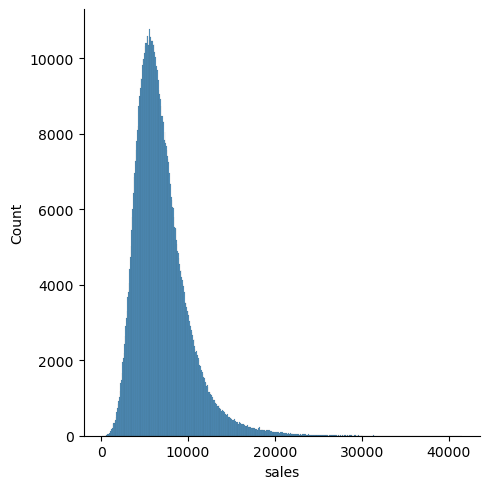

In [57]:
sns.displot(df4['sales'], kde=False)

### 4.1.2. VARIAVEL NUMERICA

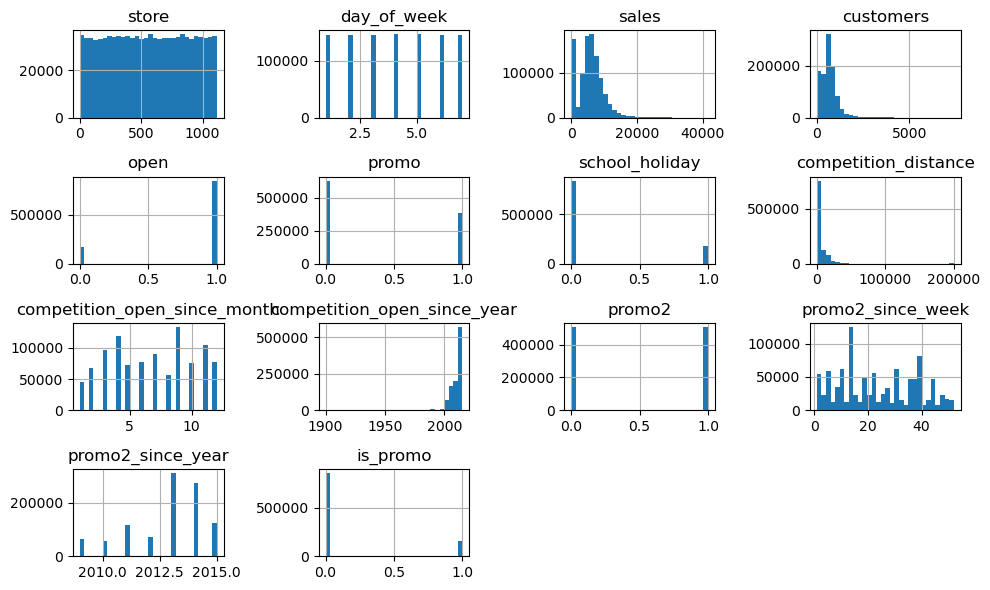

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))
atributo_num.hist(bins=30, ax=ax)

ax.set_title('Título do Gráfico')
ax.set_xlabel('Nome do Eixo X')
ax.set_ylabel('Nome do Eixo Y')

plt.tight_layout()
plt.show()

### 4.1.3. VARIAVEL CATEGORICA

In [59]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

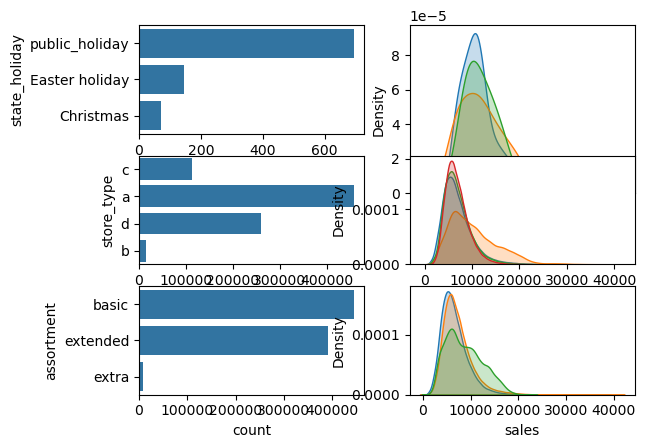

In [60]:
#state_holiday
plt.subplot(3,2,1)
a=df4[df4['state_holiday']!='regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(2,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label="public_holiday", fill=True )
sns.kdeplot(df4[df4['state_holiday']=='Easter holiday']['sales'],label="Easter holiday", fill=True )
sns.kdeplot(df4[df4['state_holiday']=='Christmas']['sales'],label="Christmas", fill=True )

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label="a", fill=True )
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label="b", fill=True )
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label="c", fill=True )
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label="d", fill=True )

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label="basic", fill=True )
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label="extended", fill=True )
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label="extra", fill=True )

## 4.2. ANALISE BIVARIADA 

### **1.** Lojas com maior sortimento deveriam vender mais.

**FALSA**

<Axes: xlabel='year_week'>

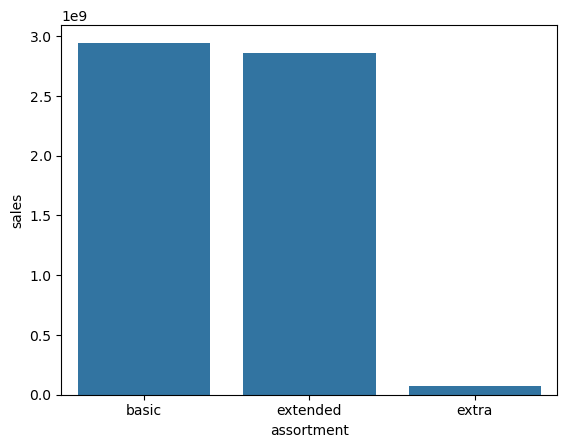

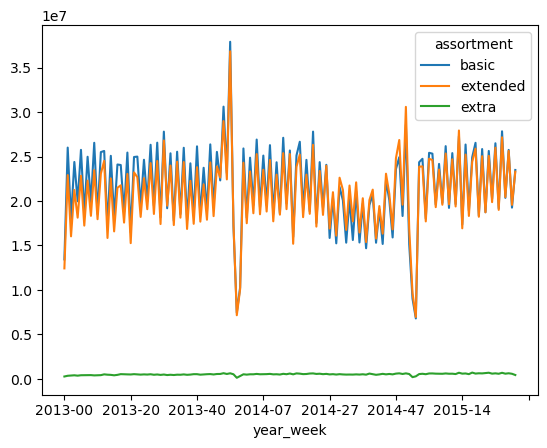

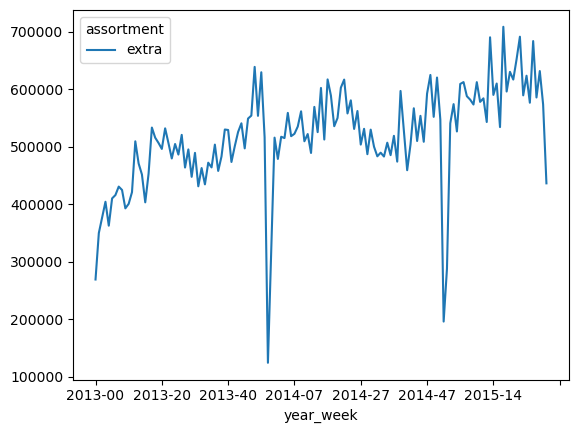

In [61]:
aux1=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1);

aux2=df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3=aux2[aux2['assortment']== 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()  

### **2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA**

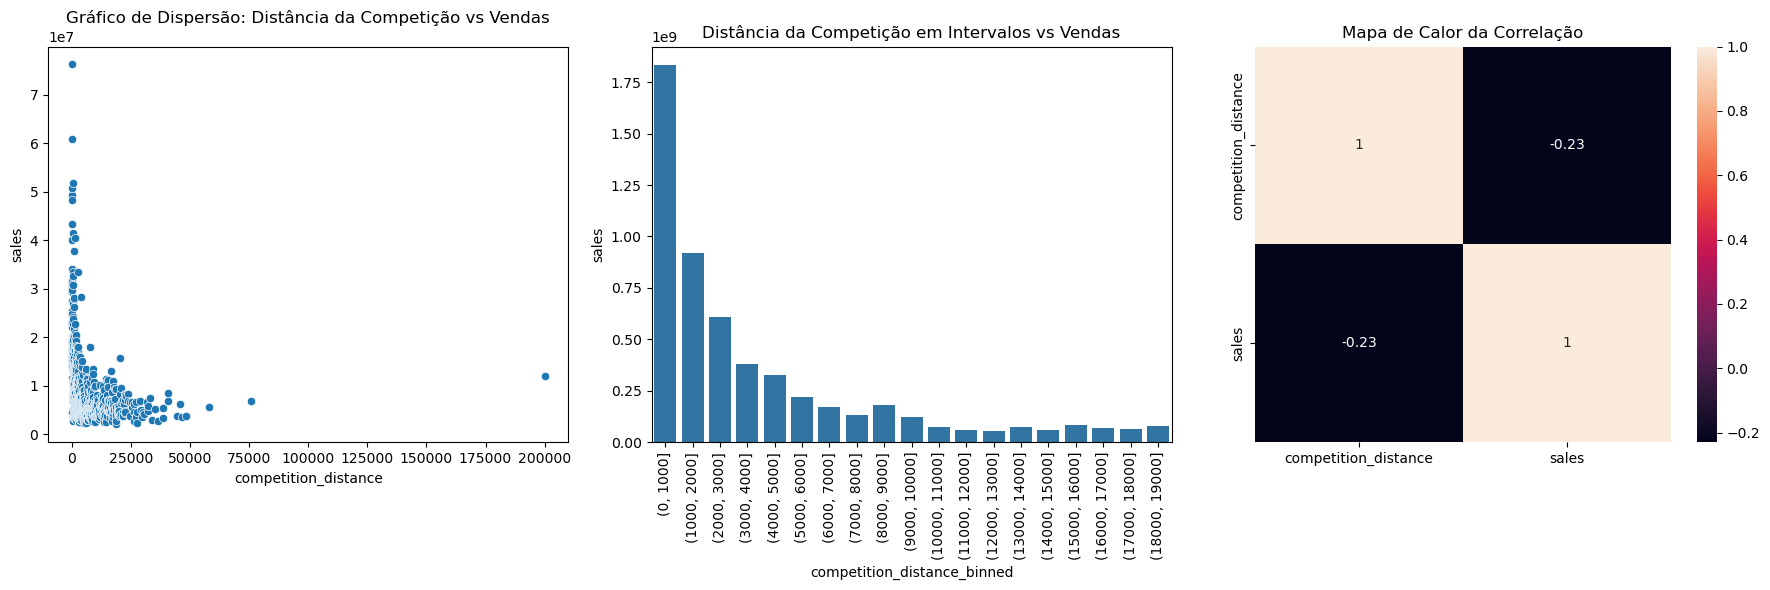

In [62]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title('Gráfico de Dispersão: Distância da Competição vs Vendas')


plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux1['competition_distance_binned'] = aux1['competition_distance_binned'].astype(str)  # Converte intervalos em strings
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

aux2['competition_distance_binned'] = pd.Categorical(aux2['competition_distance_binned'], categories=[str(b) for b in pd.cut(aux1['competition_distance'], bins=bins).cat.categories], ordered=True)

sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.title('Distância da Competição em Intervalos vs Vendas')


plt.subplot(1, 3, 3)
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method='pearson'), annot=True)
plt.title('Mapa de Calor da Correlação')

plt.tight_layout()
plt.show()

In [63]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
480,9800.0,4596143,"(9000, 10000]"
123,1360.0,11178606,"(1000, 2000]"
9,110.0,31718444,"(0, 1000]"
563,16760.0,6450589,"(16000, 17000]"


### **3.** Lojas com competidores a mais tempo deveriam vender mais

**FALSA**

<Axes: >

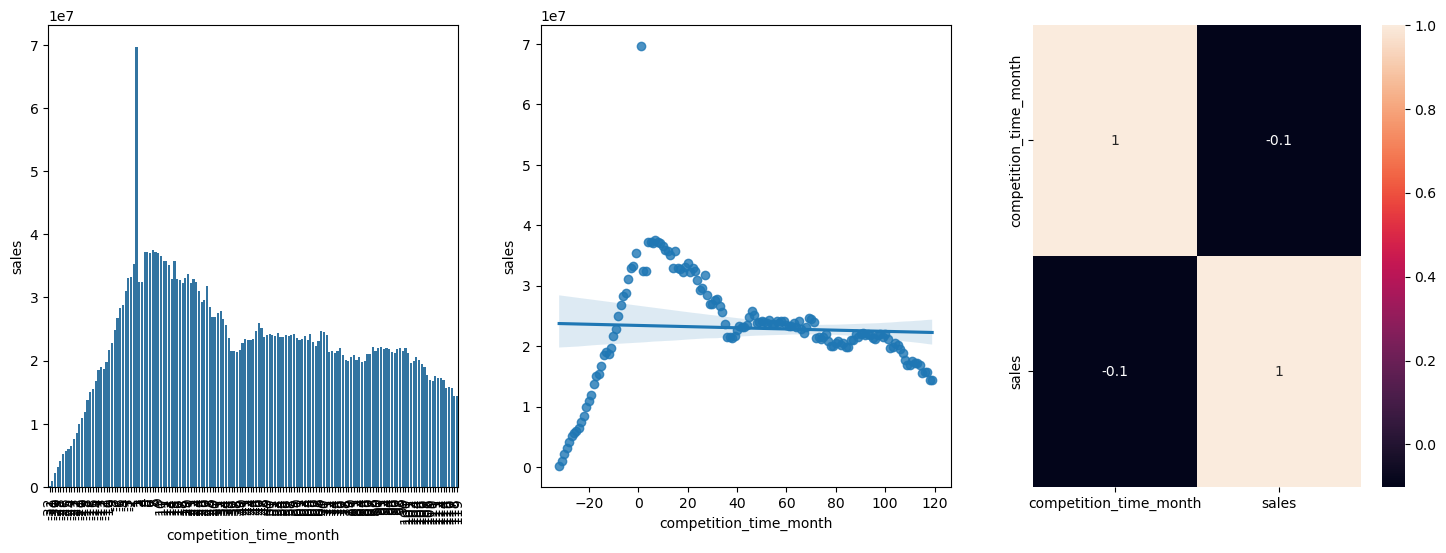

In [64]:
plt.figure(figsize=(18, 6))


plt.subplot(1,3,1)

aux1=df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month', y= 'sales', data=aux2)
plt.xticks(rotation=90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y= 'sales', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **4.** lojas com promoções ativas por mais tempo deveriam vender mais.

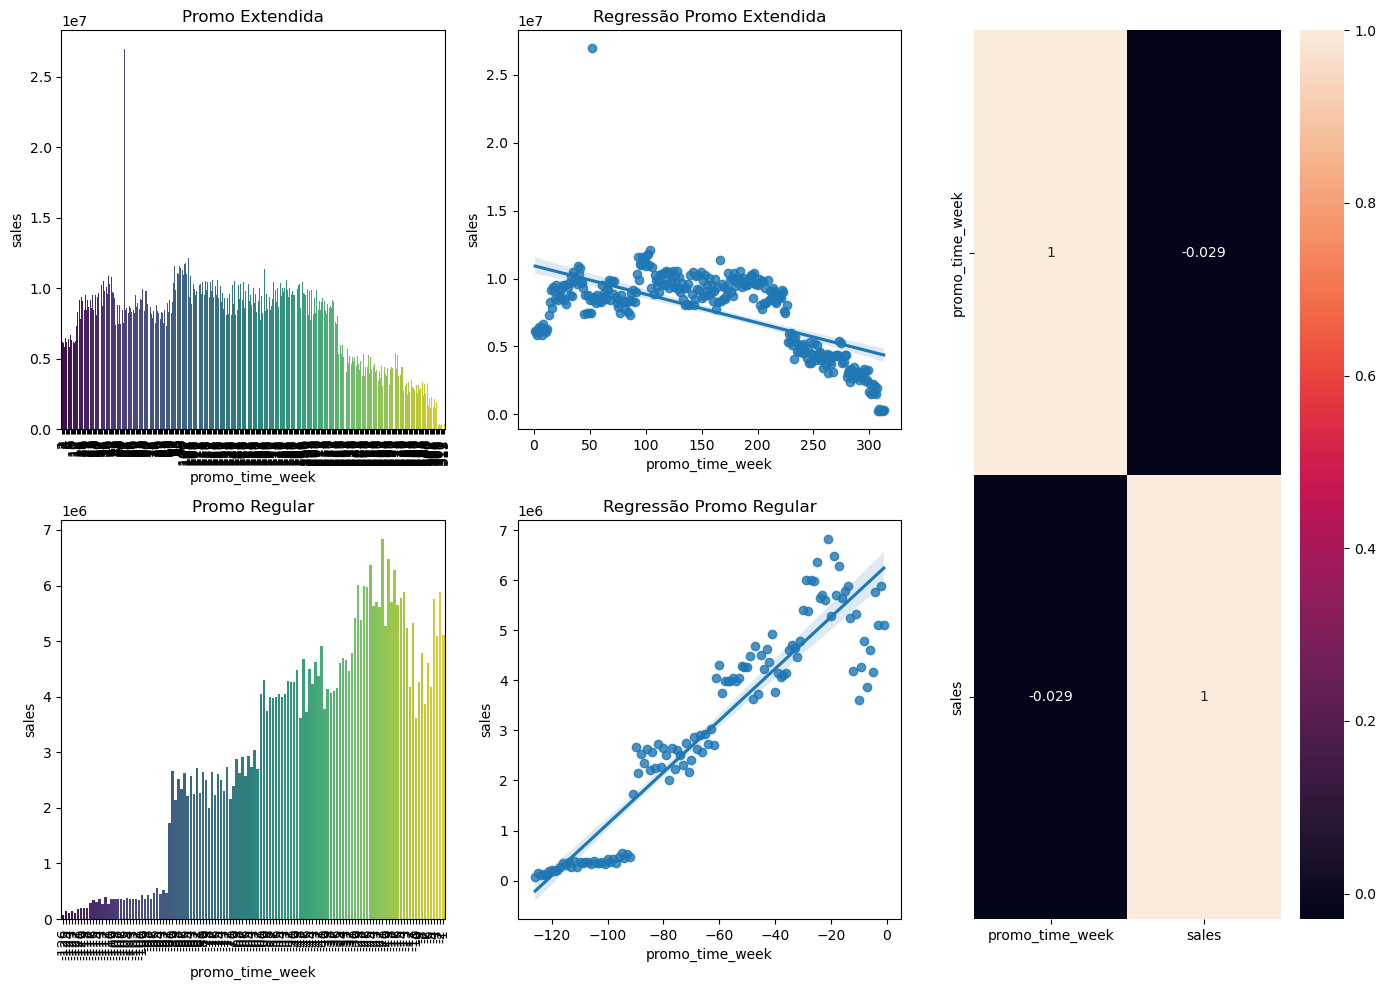

In [75]:
plt.figure(figsize=(14, 10))

grid = GridSpec(2, 3)

aux1=df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2, palette='viridis')
plt.xticks(rotation=90)
plt.title('Promo Extendida')

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Regressão Promo Extendida')

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3, palette='viridis')
plt.xticks(rotation=90)
plt.title('Promo Regular')

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Regressão Promo Regular')

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.tight_layout()
plt.show()

### **5.** lojas com mais dias de promoção deveriam vender mais.

### **6.** lojas com mais promoções conseuctivas deveriam vender mais.

## 4.3. ANALISE MULTIVARIADA 